<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

In [132]:
# Allows imports from modules in the project directory
import os
import sys
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[1]
sys.path.extend([str(PROJECT_DIRECTORY)])

DATA_DIRECTORY = Path(os.path.abspath('')).resolve().parents[3]
sys.path.extend([str(DATA_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')

Python 3.9.19 (main, Jul  7 2024, 08:52:44) 
[Clang 15.0.0 (clang-1500.3.9.4)] on darwin


In [133]:
from pathlib import Path
import tensorflow as tf
from tqdm import tqdm
import numpy as np


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, LSTM, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import utilities

In [134]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


# 0. Data Preparation

For simplicity: only choose one specific feature of the data

In [135]:
NORMALIZATION = True
COMPRESS = True
SEQ_LEN = 24

In [136]:
# Load and split dataset
data, labels, fids, velocities, angles = utilities.load_dataset(PROJECT_DIRECTORY / 'data/data_adp.pkl')
train_idx, test_idx, train_data, test_data = utilities.split_dataset(fids, labels, data, seed=42)

# Clear
del data

# Pre-processind
if NORMALIZATION:
    utilities.normalize_data(train_data)
    utilities.normalize_data(test_data)

if COMPRESS:
    utilities.compress_data(train_data, SEQ_LEN)
    utilities.compress_data(test_data, SEQ_LEN)

In [137]:
print(len(test_data), len(train_data))

test_data_sample = np.array(test_data[1000], dtype=np.float64)
test_labels = labels[test_idx]
train_labels = labels[train_idx]

print(test_data_sample.shape)

6747 26980
(24, 6)


(24, 1)


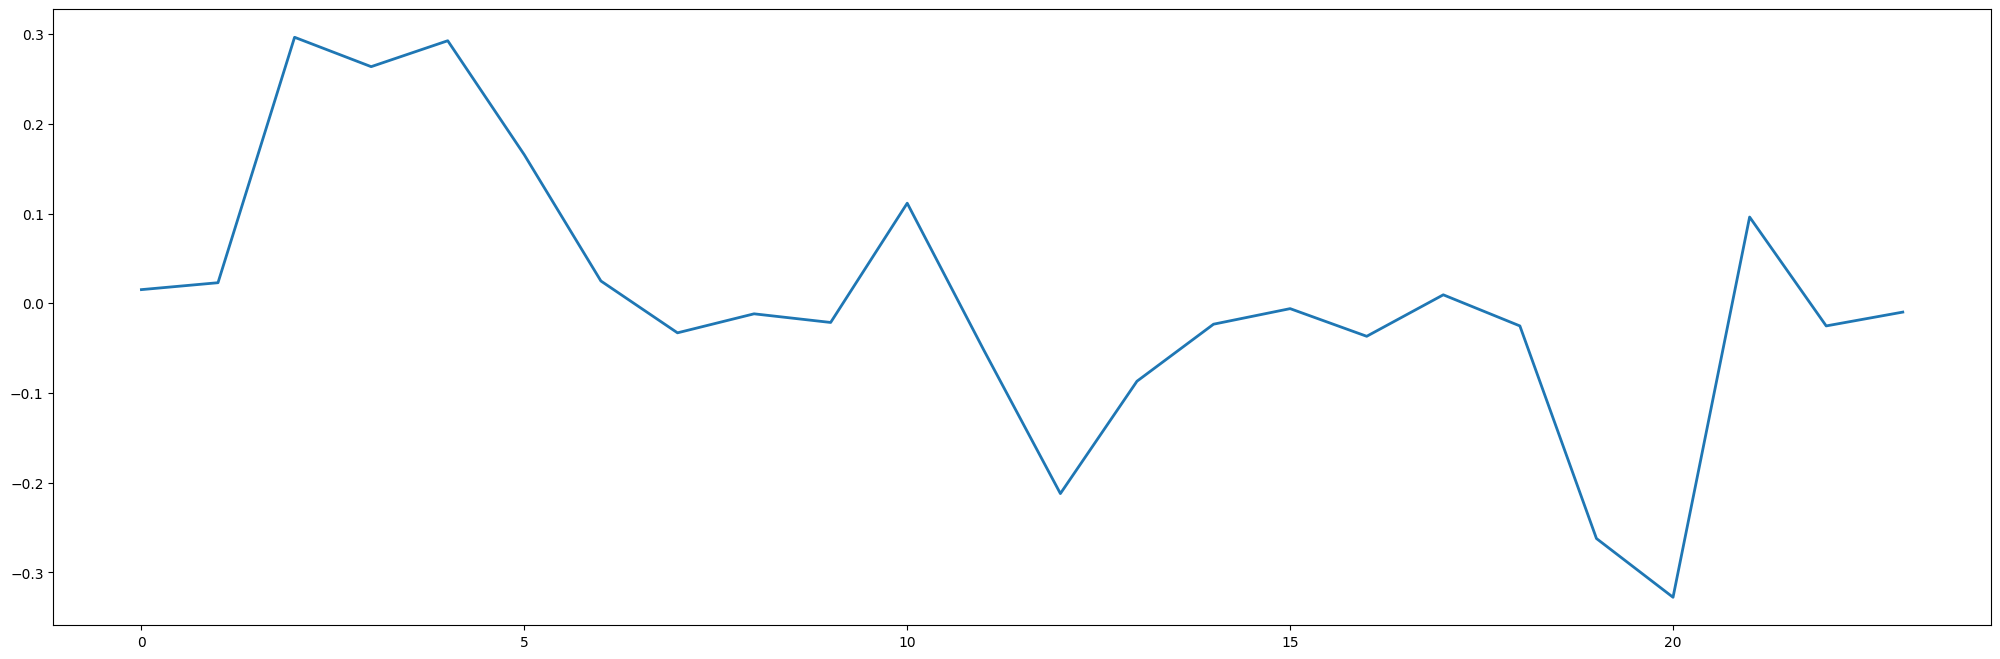

In [175]:
# Extract only first feature of time-series data
feature = 0

test_feature_data = test_data_sample[:,[feature]]

print(test_feature_data.shape)

fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(test_feature_data.shape[0])

axs.plot(sample_points, test_feature_data[:], label=r'$feature_1$ $class_0$ sample', lw=2)

In [139]:
train_data_0 = np.array(train_data)[train_labels==0]

print(train_data_0.shape)

(3041, 24, 6)


(3041, 24, 1)


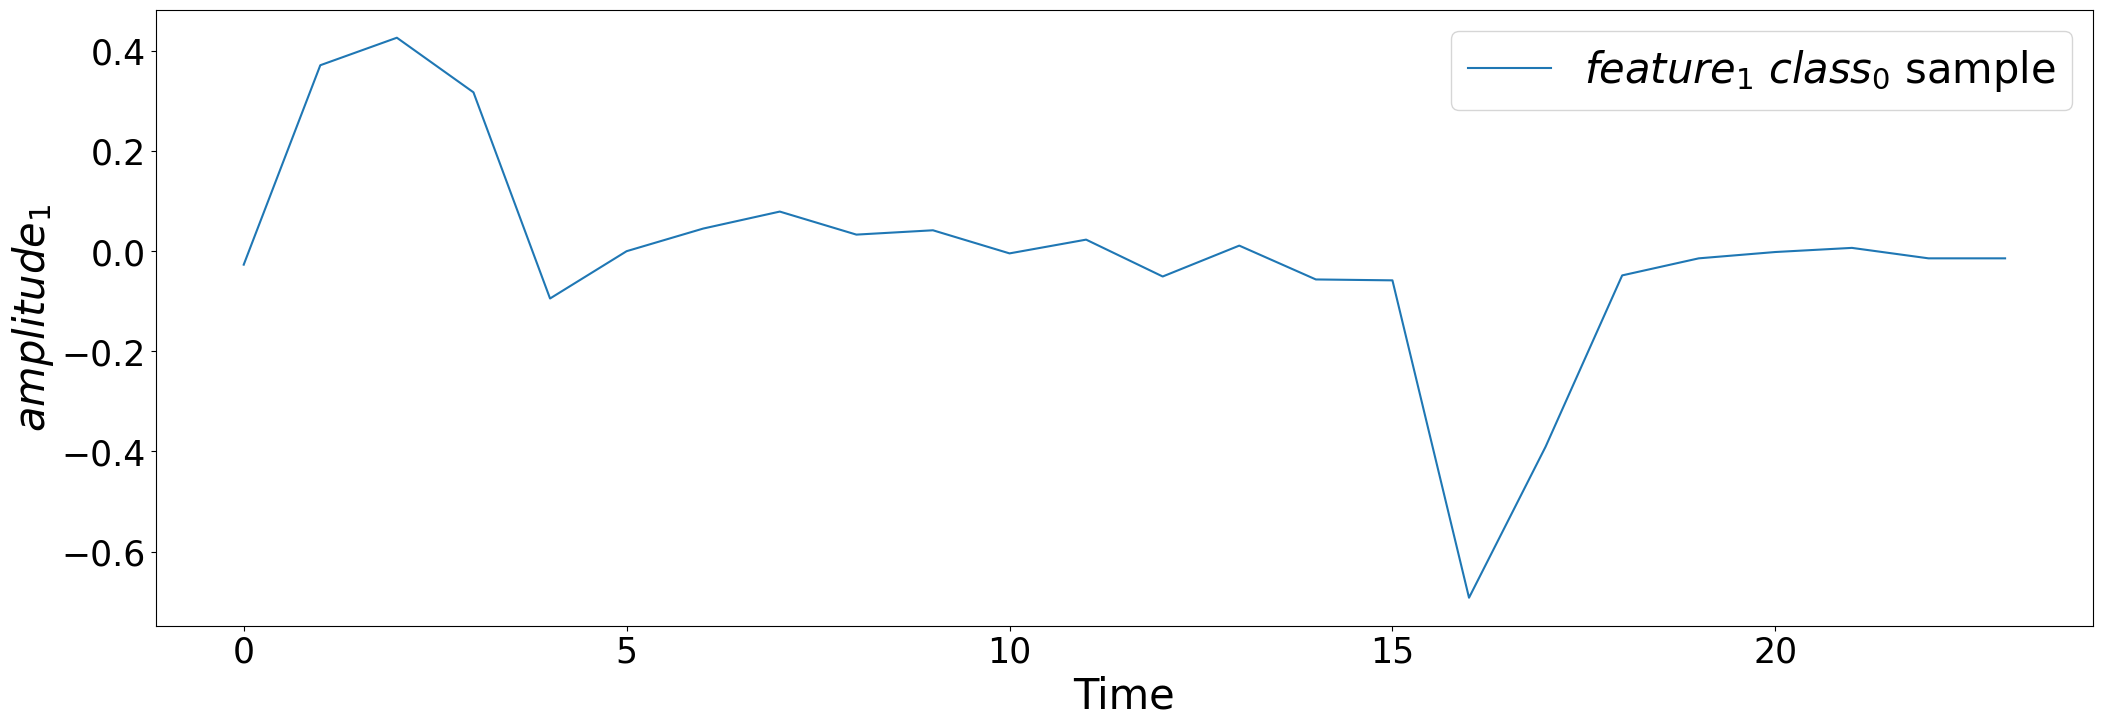

In [176]:
train_feature_data = train_data_0[:,:,[0]]

print(train_feature_data.shape)

fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(train_feature_data.shape[1])

axs.plot(sample_points, train_feature_data[0][:], label=r'$feature_1$ $class_0$ sample')
axs.legend()

axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel("Time", fontsize=30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize="30")

In [142]:
# Generate Mini Batches for Training
train_feature_dataset = tf.data.Dataset.from_tensor_slices(train_feature_data)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = len(train_feature_dataset)

# drop_remainder=True, generate equally sized batches
train_feature_dataset_batch = train_feature_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [143]:
for d in train_feature_dataset.take(1):
  print('data ', d.shape)
  print('data.shape: ', d.shape[0])

print(len(train_feature_dataset_batch))
for d in train_feature_dataset_batch.take(1):
  print('data.shape: ', d.shape)

data  (24, 1)
data.shape:  24
47
data.shape:  (64, 24, 1)


In [144]:
results_path = Path(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/timegan')
if not results_path.exists():
    results_path.mkdir()

log_dir = results_path / f'EXPERIMENT'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [145]:
real_series_iter = iter(train_feature_dataset_batch.repeat())

In [146]:
n_seq = 1 

def make_random_data():
    while True:
        yield np.random.normal(0, 1, size=(SEQ_LEN, n_seq))

In [147]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(BATCH_SIZE)
                     .repeat())

# 1. Define TimeGAN components

In [148]:
hidden_dim = 128
num_layers = 3

In [149]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [150]:
X = Input(shape=[SEQ_LEN, n_seq], name='RealData')
Z = Input(shape=[SEQ_LEN, n_seq], name='RandomData')

## RNN Network

In [151]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([LSTM(units=hidden_units,
                           return_sequences=True,
                           name=f'LSTM_{i + 1}',
                            dtype=tf.float64) for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='tanh',
                             name='OUT',
                            dtype=tf.float64)], name=name)

## Embedder & Recovery

In [152]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [153]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# 2. TimeGAN Training

In [154]:
train_steps = 1000
gamma = 1

## Loss Function

In [155]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

## 2.1: Autoencoder-Training

### Architecture

In [156]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

### Autoencoder Optimizer

In [157]:
autoencoder_optimizer = Adam()

### Autoencoder Train Step

In [158]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

### Autoencoder Train Loop

In [159]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


## 2.2: Supervised Training

In [160]:
supervisor_optimizer = Adam()

### Trainings-Schritt

In [161]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

### Trainings Loop

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

In [163]:
supervisor.summary()

Model: "Supervisor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (64, 24, 128)             131584    
                                                                 
 LSTM_2 (LSTM)               (64, 24, 128)             131584    
                                                                 
 OUT (Dense)                 (64, 24, 128)             16512     
                                                                 
Total params: 279,680
Trainable params: 279,680
Non-trainable params: 0
_________________________________________________________________


## 2.3 Joint Training

## 2.3.1 Generator

### Adversarial Architecture - Supervised

Generator vs. Discriminator

In [84]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [85]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 128)           346240    
                                                                 
 Supervisor (Sequential)     (None, 24, 128)           279680    
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             394881    
                                                                 
Total params: 1,020,801
Trainable params: 1,020,801
Non-trainable params: 0
_________________________________________________________________


### Adversarial Architecture in latent space

In [86]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [87]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 128)           346240    
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             394881    
                                                                 
Total params: 741,121
Trainable params: 741,121
Non-trainable params: 0
_________________________________________________________________


### Mean & Variance Loss of Generator

In [88]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [89]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 128)           346240    
                                                                 
 Supervisor (Sequential)     (None, 24, 128)           279680    
                                                                 
 Recovery (Sequential)       (None, 24, 1)             394881    
                                                                 
Total params: 1,020,801
Trainable params: 1,020,801
Non-trainable params: 0
_________________________________________________________________


In [90]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## 2.3.2 Discriminator

### Architecture: Real Data

In [91]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [92]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 128)           346240    
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             394881    
                                                                 
Total params: 741,121
Trainable params: 741,121
Non-trainable params: 0
_________________________________________________________________


### Optimizer

Adam Optimizer recommended as in [Jinsung Yoon et. al.](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf)

In [93]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

### Generator Train Step

In [99]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### Embedding Train Step

In [95]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

### Discriminator Train Step

In [96]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [48]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

# 3. Start Training

In [97]:
train_steps = 100

In [100]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train Embedder 2x as much as Generator
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)
        
        # Train Generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train Embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 10 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 14.5451 | g_loss_u: 15.4249 | g_loss_s: 0.0007 | g_loss_v: 0.2226 | e_loss_t0: 0.0611
    10 | d_loss: 2.2063 | g_loss_u: 1.0896 | g_loss_s: 0.0003 | g_loss_v: 0.1084 | e_loss_t0: 0.0083
    20 | d_loss: 2.2794 | g_loss_u: 1.3247 | g_loss_s: 0.0002 | g_loss_v: 0.1016 | e_loss_t0: 0.0048
    30 | d_loss: 2.1466 | g_loss_u: 1.3290 | g_loss_s: 0.0001 | g_loss_v: 0.0817 | e_loss_t0: 0.0072
    40 | d_loss: 2.1196 | g_loss_u: 1.3250 | g_loss_s: 0.0001 | g_loss_v: 0.0619 | e_loss_t0: 0.0109
    50 | d_loss: 2.1242 | g_loss_u: 1.1686 | g_loss_s: 0.0001 | g_loss_v: 0.0647 | e_loss_t0: 0.0062
    60 | d_loss: 2.0450 | g_loss_u: 1.1587 | g_loss_s: 0.0000 | g_loss_v: 0.0798 | e_loss_t0: 0.0096
    70 | d_loss: 2.0528 | g_loss_u: 1.2013 | g_loss_s: 0.0001 | g_loss_v: 0.0657 | e_loss_t0: 0.0041
    80 | d_loss: 1.9267 | g_loss_u: 1.3184 | g_loss_s: 0.0000 | g_loss_v: 0.0628 | e_loss_t0: 0.0048
    90 | d_loss: 2.2879 | g_loss_u: 1.3415 | g_loss_s: 0.0000 | g_loss_v: 0.0472 | e_loss

# 4. Store Model

In [101]:
synthetic_data.save(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/timegan/TimeGAN/model.h5', save_format='h5')

In [104]:
model = tf.keras.models.load_model(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/timegan/TimeGAN/model.h5')

## 5. Generate Synthetic Data

In [105]:
generated_data = []
for i in tqdm(range(10)):
    Z_ = next(random_series)
    d = model(Z_)
    generated_data.append(d)

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


In [106]:
np.shape(generated_data)

(10, 64, 24, 1)

In [107]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(640, 24, 1)

In [164]:
# Store & load data
#np.save(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/timegan/generated_data.npy', generated_data)
generated_data = np.load(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/TimeGAN/generated_data.npy')

## 6. Create Plots

(3041, 24, 1)


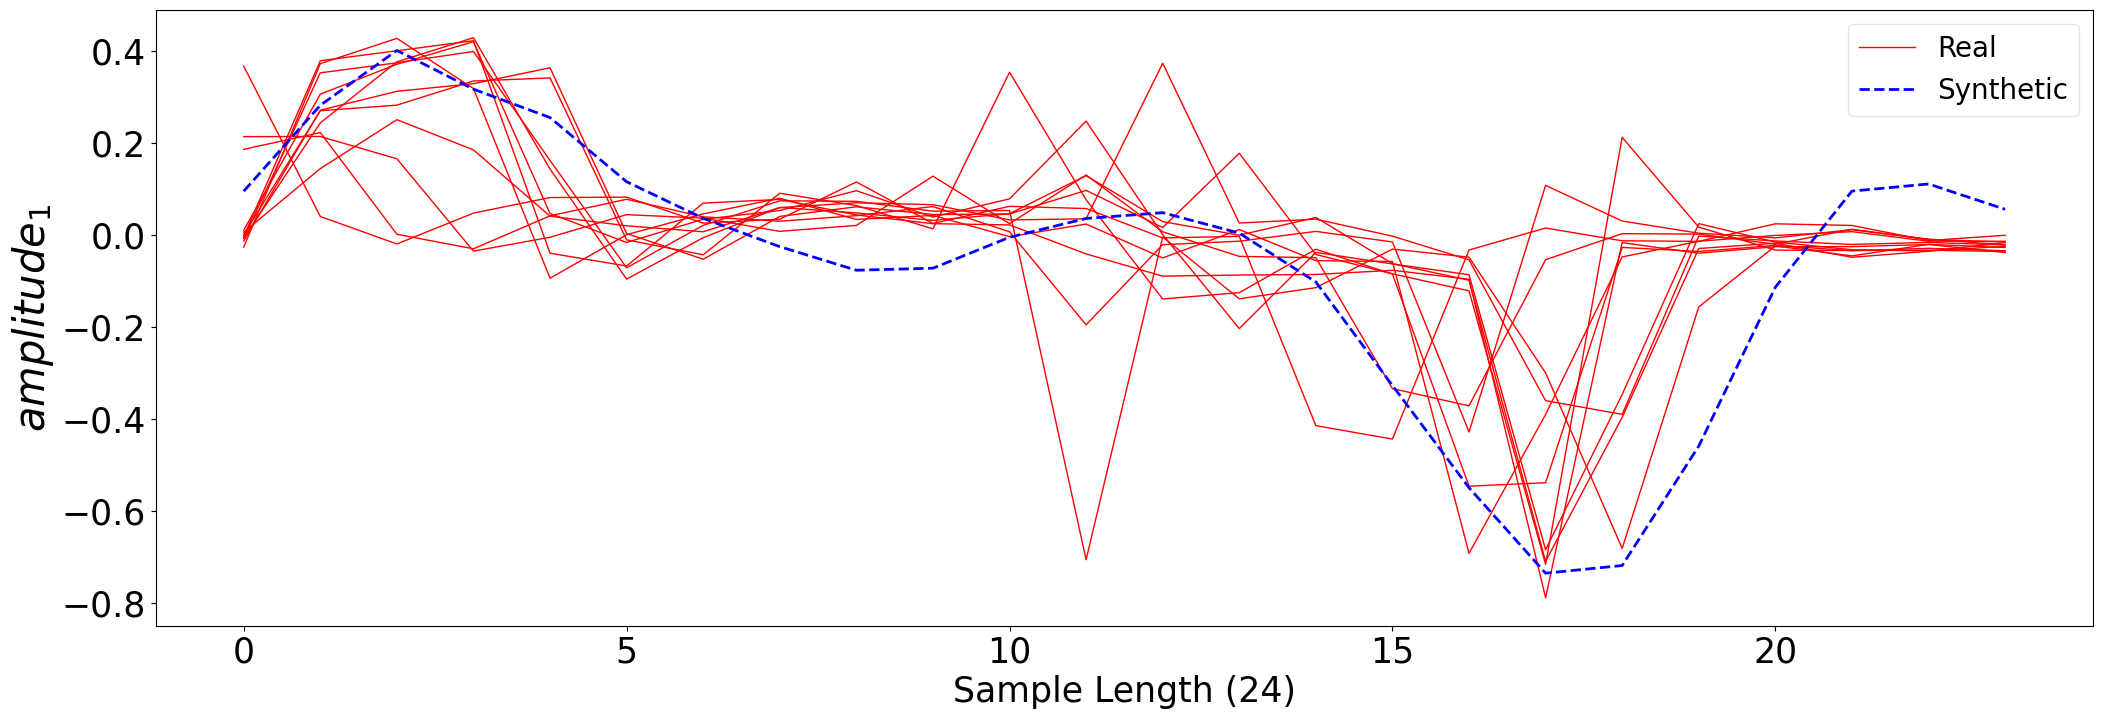

In [166]:
columns = ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6"]

train_feature_data = train_data_0[:,:,[0]]

print(train_feature_data.shape)

fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_data.shape[1])

axs.plot(sample_points, train_feature_data[244][:], 'r-', label='Real', lw=1)
for i in range(10):
    axs.plot(sample_points, train_feature_data[i][:], 'r-', lw=1)
axs.plot(sample_points, generated_data[4][:], 'b--', label='Synthetic', lw=2)

axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel(f"Sample Length ({len(sample_points)})", fontsize=25)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

axs.tick_params(axis='x')
axs.tick_params(axis='y')

axs.spines['left'].set_color('black')
axs.spines['top'].set_color('black') 
axs.spines['bottom'].set_color('black') 
axs.spines['right'].set_color('black')

axs.legend(fontsize="20", framealpha=0.5)

In [167]:
print(generated_data.shape)
print(train_feature_data.shape)

mean_generated_sample = np.array([np.mean(i) for i in np.transpose(generated_data, (1,2,0))])
mean_train_feature_data = np.array([np.mean(i) for i in np.transpose(train_feature_data, (1,2,0))])


print(mean_generated_sample.shape)
print(mean_train_feature_data.shape)

(640, 24, 1)
(3041, 24, 1)
(24,)
(24,)


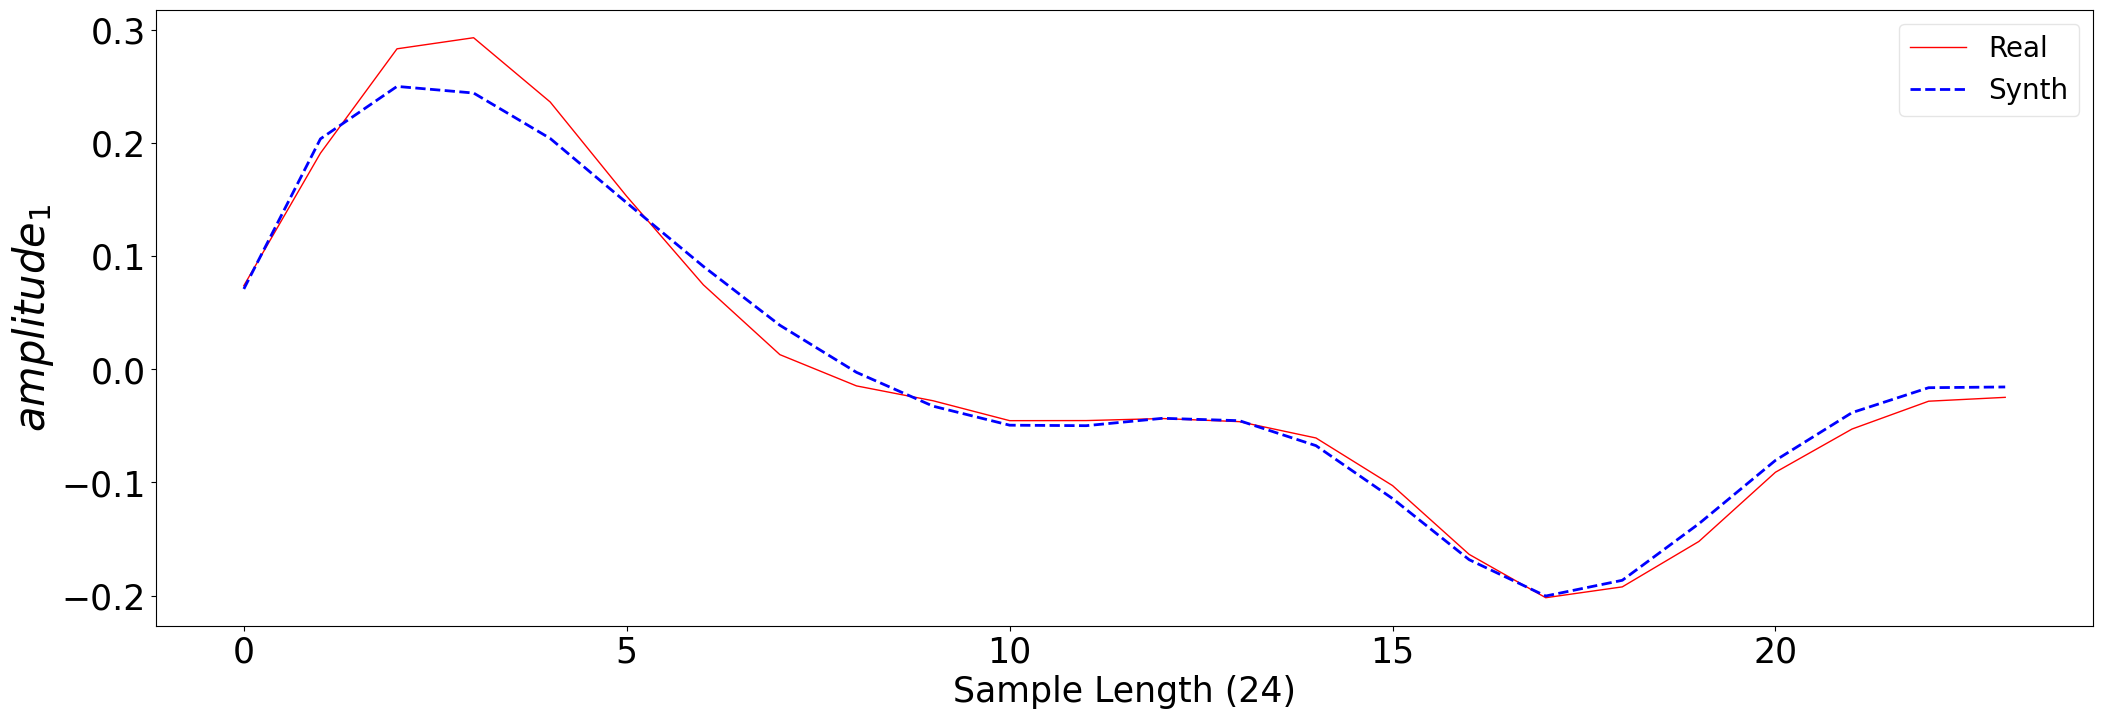

In [168]:
fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_data.shape[1])

axs.plot(sample_points, mean_train_feature_data, 'r-', label='Real', lw=1)
axs.plot(sample_points, mean_generated_sample,'b--', label='Synth', lw=2)

axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel(f"Sample Length ({len(sample_points)})", fontsize=25)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

axs.tick_params(axis='x')
axs.tick_params(axis='y')

axs.spines['left'].set_color('black')
axs.spines['top'].set_color('black') 
axs.spines['bottom'].set_color('black') 
axs.spines['right'].set_color('black')

axs.legend(fontsize="20", framealpha=0.5)

(3041, 24, 1)


Text(0.5, 0.98, 'Synthetic and real sample of $feature_1$ of Label $class_0$')

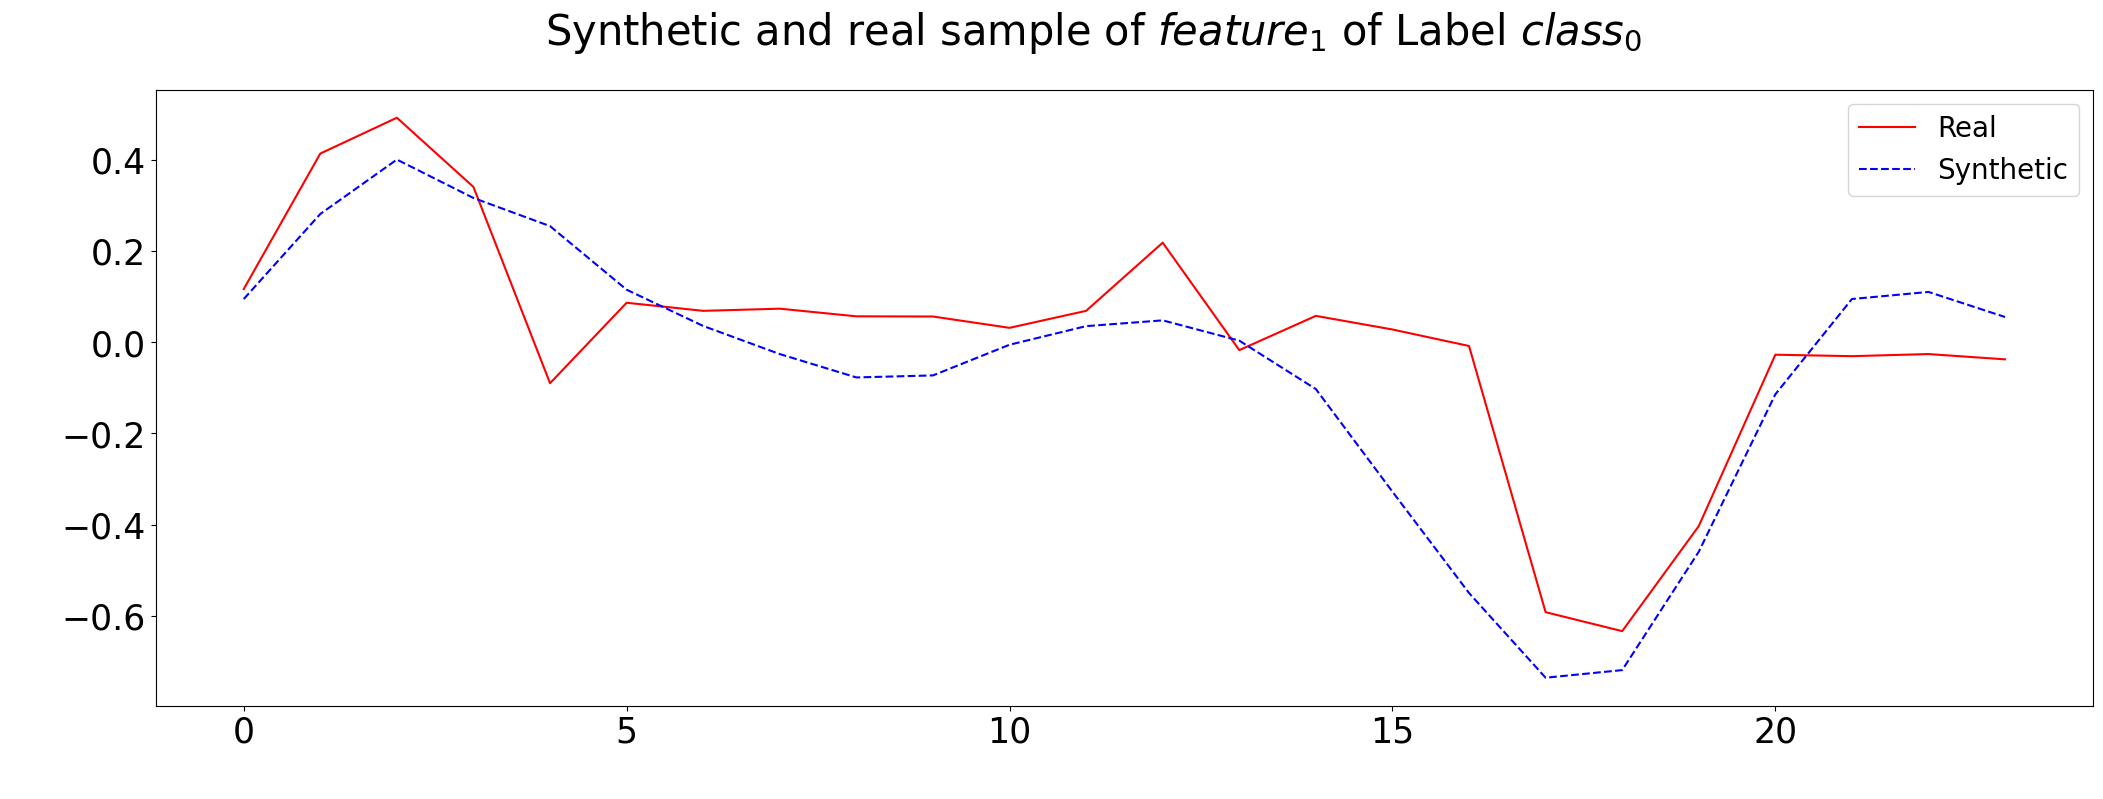

In [174]:
columns = ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6"]

train_feature_data = train_data_0[:,:,[0]]

print(train_feature_data.shape)

fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_data.shape[1])

axs.plot(sample_points, train_feature_data[247][:], 'r-', label='Real')
axs.plot(sample_points, generated_data[4][:], 'b--', label='Synthetic')

axs.set_ylabel(r"$amplitude_1$", fontsize=30, color='w')
axs.set_xlabel(f"Sample Length {len(sample_points)})", fontsize=25, color='w')

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize="20")

fig.suptitle("Synthetic and real sample of $feature_1$ of Label $class_0$", fontsize=30)

In [170]:
print(generated_data.shape)
print(train_feature_data.shape)

mean_generated_sample = np.array([np.mean(i) for i in np.transpose(generated_data, (1,2,0))])
mean_train_feature_data = np.array([np.mean(i) for i in np.transpose(train_feature_data, (1,2,0))])


print(mean_generated_sample.shape)
print(mean_train_feature_data.shape)

(640, 24, 1)
(3041, 24, 1)
(24,)
(24,)


Text(0.5, 0.98, 'Synthetic and real mean of $feature_1$ of Label $class_0$')

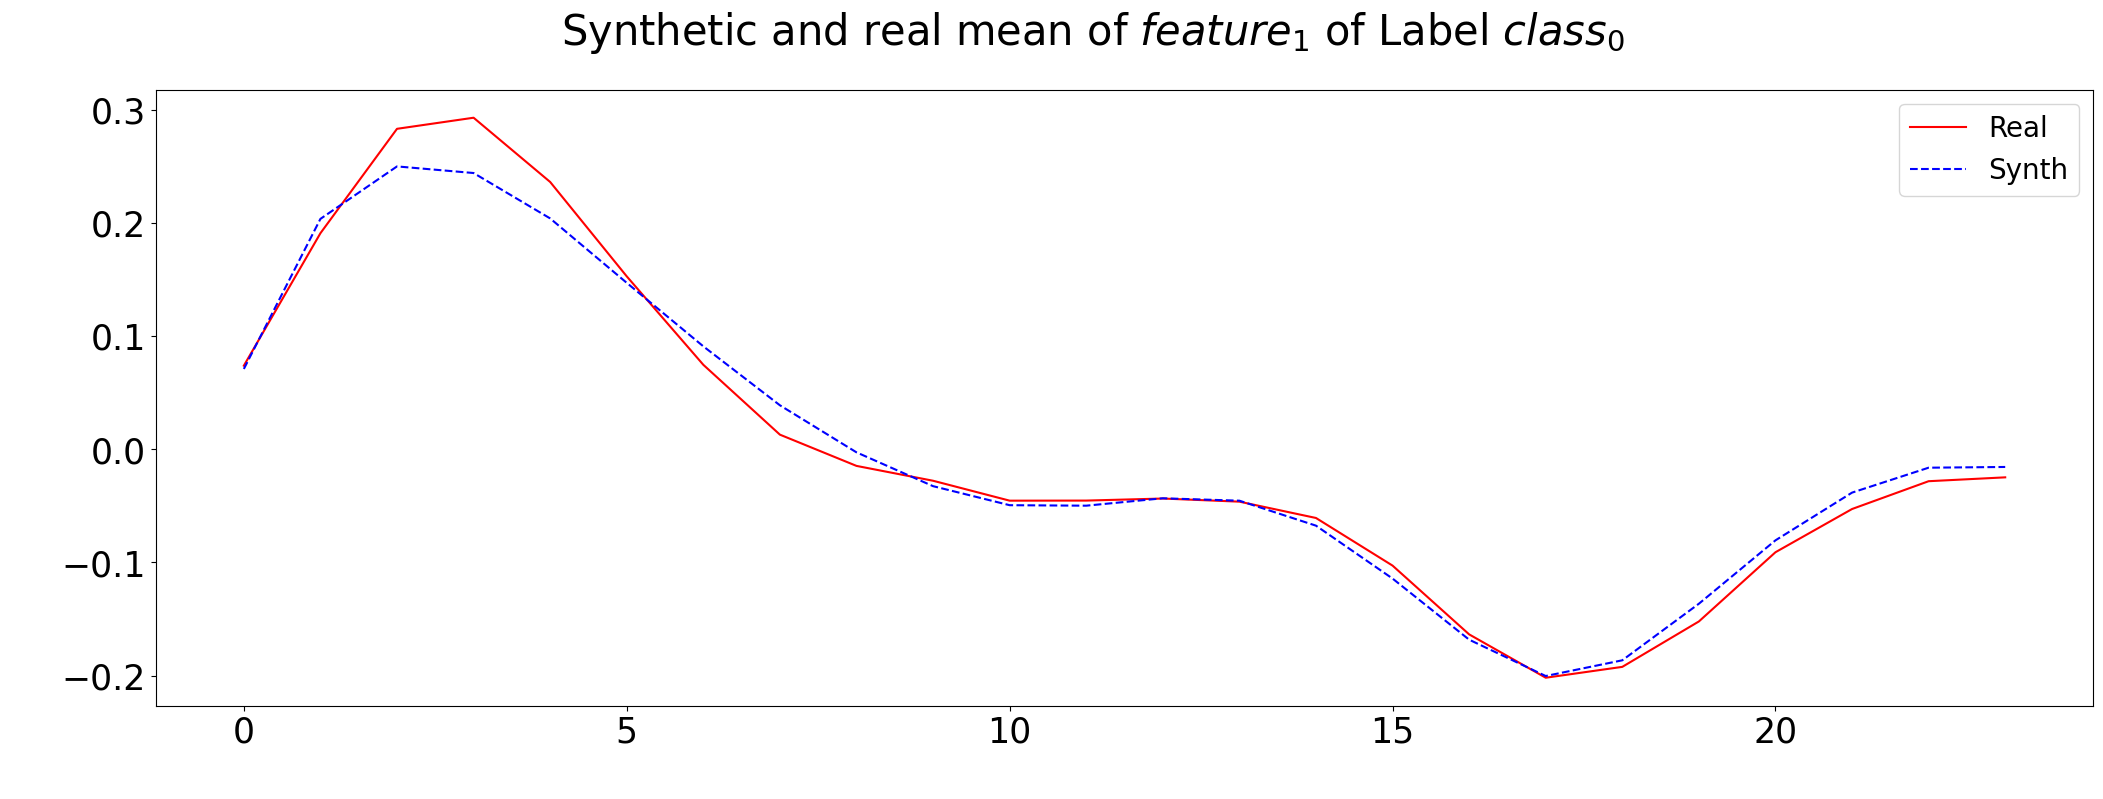

In [173]:
fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_data.shape[1])

axs.plot(sample_points, mean_train_feature_data, 'r-', label='Real')
axs.plot(sample_points, mean_generated_sample,'b--', label='Synth')
axs.legend()

axs.set_ylabel(r"$amplitude_1$", fontsize=30, color='w')
axs.set_xlabel(f"Sample Length {len(sample_points)})", fontsize=25, color='w')

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize="20")

fig.suptitle("Synthetic and real mean of $feature_1$ of Label $class_0$", fontsize=30)